LSTM Модел за предвидување на температурата за град Скопје и инсталација на Arduino со помош на ELL Microsoft

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense,Dropout
import matplotlib.pyplot as plt

Читање на датасет, претворање на колоната date во datetime и сортирање, селекција на конони

In [3]:
data = pd.read_csv('/content/SkopjeWeather.csv')

data['date'] = pd.to_datetime(data['date'])
data = data.sort_values('date')

features = ['tavg', 'tmin', 'tmax']
data_selected = data[features]
data_selected

,tavg,tmin,tmax
0,7.8,-3.7,11.6
1,4.9,-1.4,11.5
2,4.4,-1.0,8.6
3,2.8,0.2,7.5
4,-1.6,-3.4,0.4
...,...,...,...
584,23.9,18.1,33.6
585,24.4,17.6,32.3
586,23.3,18.4,29.5
587,17.9,17.1,20.3


In [4]:
data_selected.isnull().sum()

,0
tavg,0
tmin,0
tmax,0


Нормализација на податоците

In [5]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data_selected)

Kреирање на секвенци за LSTM

In [6]:
def seq(data, sequence_length=1):
    X = []
    y = []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i + sequence_length])
        y.append(data[i + sequence_length, 0])
    return np.array(X), np.array(y)

sequence_length = 1
X, y = seq(scaled_data, sequence_length)

Пделба на податоците за тренирање и тестирање

In [7]:
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [8]:
X_train = X_train.reshape((X_train.shape[0], sequence_length, X_train.shape[2]))
X_test = X_test.reshape((X_test.shape[0], sequence_length, X_test.shape[2]))

Креирање на модел

In [20]:
model = Sequential()
model.add(LSTM(50, return_sequences=False,activation='relu', input_shape=(sequence_length, X_train.shape[2])))

model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Тренинг на моделот

In [21]:
history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test), verbose=1)

Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.1870 - val_loss: 0.3091
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0887 - val_loss: 0.1088
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0244 - val_loss: 0.0177
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0076 - val_loss: 0.0086
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0063 - val_loss: 0.0075
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0060 - val_loss: 0.0061
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0048 - val_loss: 0.0048
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0041 - val_loss: 0.0047
Epoch 9/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0036 - val_loss: 0.0039
Epoch 10/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0040 - val_loss: 0.0039
Epoch 11/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0035 - val_loss: 0.0038
Epoch 12/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0034 - val_l

Предвидување

In [22]:
predictions = model.predict(X_test)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Трансформација на предвидуваните и вистинските вредност

In [23]:
predictions_rescaled = scaler.inverse_transform(np.concatenate((predictions, np.zeros((predictions.shape[0], X_test.shape[2] - 1))), axis=1))[:, 0]
y_test_rescaled = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], X_test.shape[2] - 1))), axis=1))[:, 0]

Визуелизација

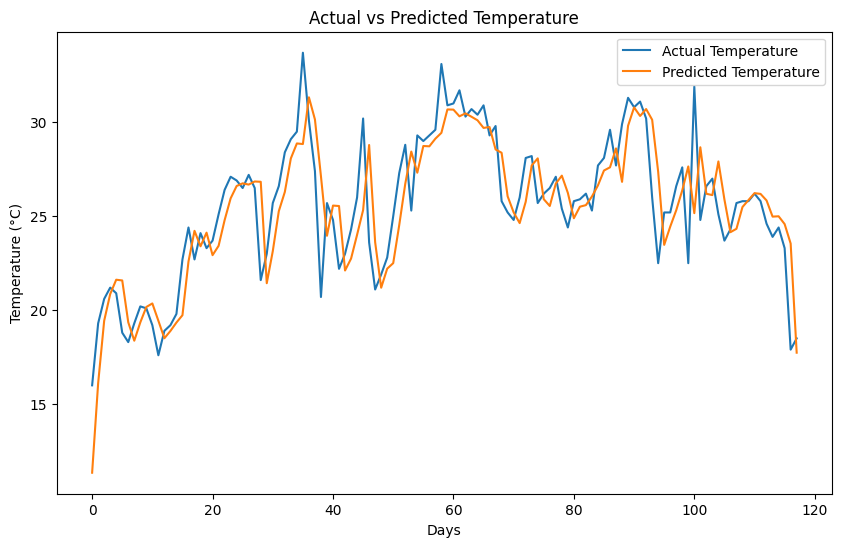

In [24]:
plt.figure(figsize=(10,6))
plt.plot(y_test_rescaled, label='Actual Temperature')
plt.plot(predictions_rescaled, label='Predicted Temperature')
plt.title('Actual vs Predicted Temperature')
plt.xlabel('Days')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.show()

Mean Squared Error

In [25]:
mse = np.mean((predictions_rescaled - y_test_rescaled)**2)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 4.733741696802734


In [26]:
!pip install tf2onnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 455.8/455.8 kB 29.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 85.7 MB/s eta 0:00:00


In [27]:
!pip install onnx

In [28]:
model.save('weather_model.h5')

In [30]:
import tensorflow as tf
from tensorflow.keras.models import load_model

model = load_model('weather_model.h5')

model.export('weather_model')

Saved artifact at 'weather_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 1, 3), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  138187019304656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138187019785968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138187019787728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138187019793712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138187019796000: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [31]:
!python -m tf2onnx.convert --saved-model weather_model --output "model.onnx"

2024-09-25 15:21:30.132154: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-25 15:21:30.157017: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-25 15:21:30.163944: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-25 15:21:31.365850: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/usr/lib/python3.10/runpy.py:126: RuntimeWarning: 'tf2onnx.convert' found in sys.modules after import of package 'tf2onnx', but prior to execution of 'tf2onnx.convert'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
2

In [32]:
import onnx

model = onnx.load('/content/model.onnx')

print(onnx.helper.printable_graph(model.graph))

graph tf2onnx (
  %input_layer_1[FLOAT, unk__249x1x3]
) initializers (
  %new_shape__55[INT64, 3]
  %const_starts__43[INT64, 1]
  %const_fold_opt__68[INT32, 1]
  %const_fold_opt__67[FLOAT, scalar]
  %const_fold_opt__130[FLOAT, scalar]
  %const_ends__44[INT64, 1]
  %const_ends__26[INT64, 1]
  %const_axes__47[INT64, 1]
  %StatefulPartitionedCall/sequential_1_1/lstm_1_1/while/loop_counter:0[INT32, scalar]
  %StatefulPartitionedCall/sequential_1_1/lstm_1_1/Max:0[INT64, scalar]
  %StatefulPartitionedCall/sequential_1_1/dense_1_1/Cast/ReadVariableOp:0[FLOAT, 50x1]
  %StatefulPartitionedCall/sequential_1_1/dense_1_1/Add/ReadVariableOp:0[FLOAT, 1]
  %Func/StatefulPartitionedCall/input/_3:0[FLOAT, 200]
  %Func/StatefulPartitionedCall/input/_2:0[FLOAT, 50x200]
  %Func/StatefulPartitionedCall/input/_1:0[FLOAT, 3x200]
) {
  %__inference_sequential_1_1_lstm_1_1_while_cond_14665_frozen_355_sequential_1_1/lstm_1_1/while/Less:0 = Less(%const_fold_opt__130, %const_fold_opt__67)
  %__inference_sequentia